# Google Play Music and YouTube Music activity analysis

Grab your activity from https://takeout.google.com/

In [27]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import json
import pylast
from wordcloud import WordCloud
from textwrap import fill

In [7]:
my_activity = pd.DataFrame(columns=['artist', 'song', 'datetime', 'platform'])

with open('My Activity/Google Play Music/My Activity.json') as file:
    input_data = json.load(file)
    for i in input_data:
        if (i['header'] == 'Google Play Music' and
                i['title'].startswith('Listened to ')):
            my_activity = my_activity.append({
                    'artist': i['description'].lower(), 
                    'song': i['title'].replace('Listened to ', '').lower(), 
                    'datetime': i['time'],
                    'platform': 'Play Music'},
                ignore_index=True)

with open('My Activity/YouTube/My Activity.json') as file:
    input_data = json.load(file)
    for i in input_data:
        if (i['header'] == 'YouTube Music' and 
                i['title'].startswith('Watched ') and
                i['subtitles'][0]['name'].endswith(' - Topic')):
            my_activity = my_activity.append({
                    'artist': i['subtitles'][0]['name'].replace(' - Topic', '').lower(), 
                    'song': i['title'].replace('Watched ', '').lower(), 
                    'datetime': i['time'],
                    'platform': 'YouTube Music'},
                ignore_index=True)

In [8]:
my_activity['datetime'] = pd.to_datetime(my_activity.datetime)
my_activity['month_name'] = my_activity.datetime.dt.strftime('%b')
my_activity['weekday_name'] = my_activity.datetime.dt.strftime('%a')
my_activity['hour'] = my_activity.datetime.dt.hour
my_activity['month_count'] = my_activity.datetime.dt.year * 12 + my_activity.datetime.dt.month
my_activity['month_year_name'] = my_activity.datetime.dt.strftime('%b %Y')
my_activity['min_count'] = my_activity.datetime.dt.hour * 60 + my_activity.datetime.dt.minute

my_activity = my_activity.sort_values('datetime')

In [35]:
my_activity.loc[my_activity.artist == 'эрик клэптон', 'artist'] = 'eric clapton'

In [36]:
my_activity.head()

,artist,song,datetime,platform,month_name,weekday_name,hour,month_count,month_year_name,min_count
12772,alt-j,breezeblocks,2017-07-15 05:40:47.715000+00:00,Play Music,Jul,Sat,5,24211,Jul 2017,340
12771,alt-j,(guitar),2017-07-15 05:44:35.154000+00:00,Play Music,Jul,Sat,5,24211,Jul 2017,344
12770,скриптонит,на должном,2017-07-17 07:52:53.619000+00:00,Play Music,Jul,Mon,7,24211,Jul 2017,472
12769,скриптонит,сны,2017-07-17 07:53:01.007000+00:00,Play Music,Jul,Mon,7,24211,Jul 2017,473
12768,скриптонит,вниз,2017-07-17 07:53:11.411000+00:00,Play Music,Jul,Mon,7,24211,Jul 2017,473


## Period of activity

In [10]:
min_date = my_activity.datetime.min().strftime('%d.%m.%Y')
max_date = my_activity.datetime.max().strftime('%d.%m.%Y')
print(min_date + ' - ' + max_date)

15.07.2017 - 14.07.2019


## Count of listening

In [11]:
len(my_activity.index)

14071

## Count of songs

In [12]:
len(my_activity.groupby(['artist', 'song'], as_index=False).any().index)

4809

## Count of artists

In [13]:
my_activity.artist.nunique()

1034

## Proportion of listening by platform

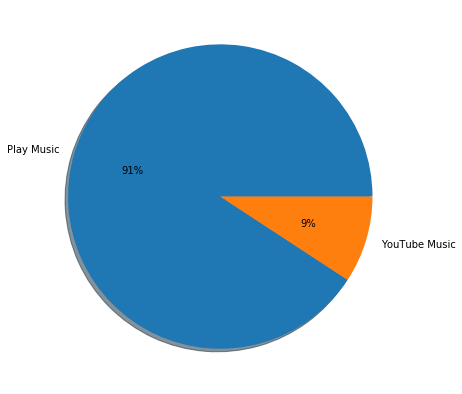

In [14]:
plt.figure(figsize=(7, 7))
data = my_activity.groupby('platform', as_index=False).agg({'datetime': 'count'})
plt.pie(x=data.datetime, labels=data.platform, autopct='%.0f%%', shadow=True)
plt.show()

## Bar chart of listening by month

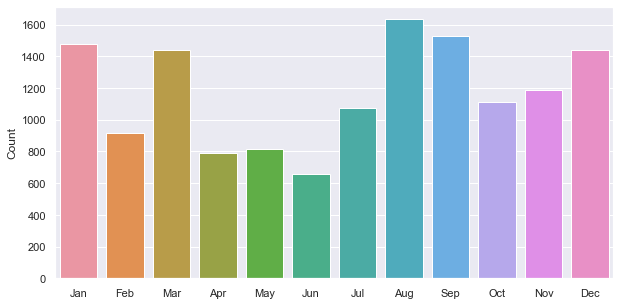

In [15]:
sns.set(rc={'figure.figsize':(10, 5)})
month_order = pd.date_range(pd.Timestamp('2019'), periods=12, freq='m').strftime('%b')
fig = sns.countplot(x='month_name', order=month_order, data=my_activity)
fig.set(xlabel='', ylabel='Count')
plt.show()

## Bar chart of listening by hour

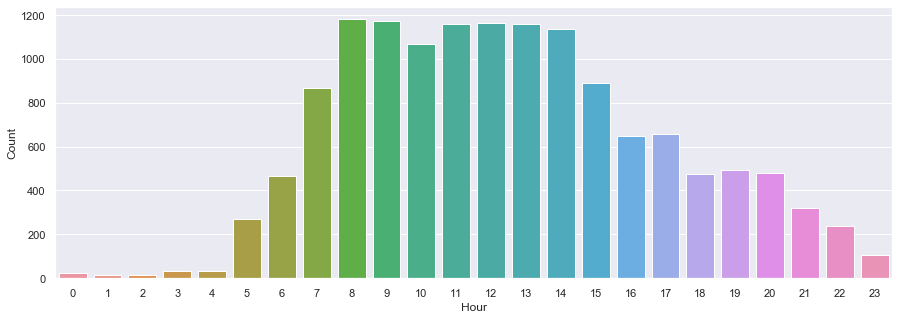

In [16]:
sns.set(rc={'figure.figsize':(15, 5)})
fig = sns.countplot(x='hour', data=my_activity)
fig.set(xlabel='Hour', ylabel='Count')
plt.show()

## Violin plot of listening by time and day of week

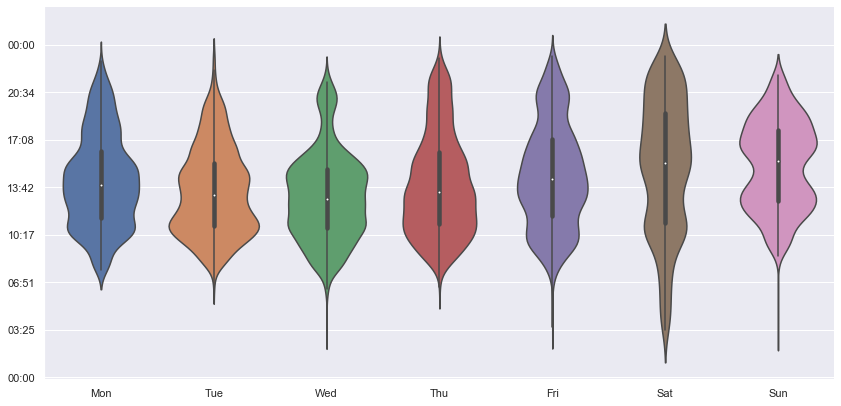

In [17]:
weekday_order = pd.date_range(pd.Timestamp('2019-01-07'), periods=7, freq='d').strftime('%a')
fig = sns.catplot(x="weekday_name", y="min_count", kind="violin", 
                  order=weekday_order, data=my_activity, height=6, 
                  aspect=2);
labels = [''] + pd.date_range('2019', periods=8, freq='205.715min').strftime('%H:%M').tolist()
fig.set(xlabel='', ylabel='', yticklabels=labels)

plt.show()

## Bar chart of listening by day of week

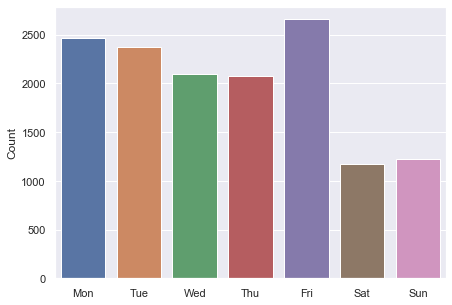

In [18]:
sns.set(rc={'figure.figsize':(7, 5)})
weekday_order = pd.date_range(pd.Timestamp('2019-01-07'), periods=7, freq='d').strftime('%a')
fig = sns.countplot(x='weekday_name',order=weekday_order, data=my_activity)
fig.set(xlabel='', ylabel='Count')
plt.show()

## Histogram of listening by period

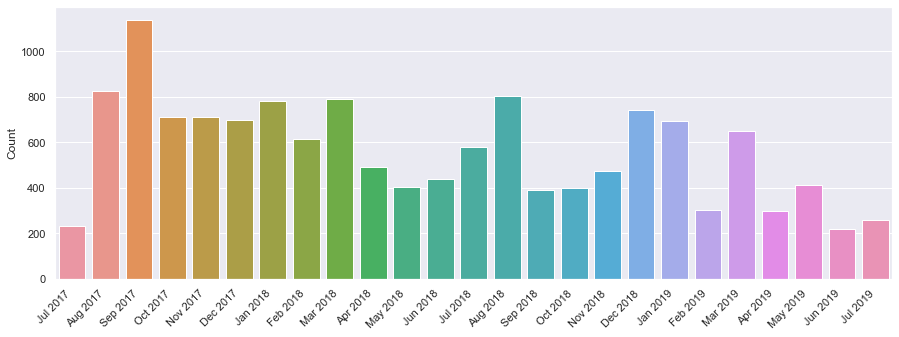

In [19]:
sns.set(rc={'figure.figsize':(15, 5)})
periods = my_activity.month_year_name.nunique()
period_order = pd.date_range(
        my_activity.datetime.min(), 
        periods=periods, freq='m'). \
    strftime('%b %Y')
fig = sns.countplot(x='month_year_name', order=period_order, data=my_activity)
labels = fig.get_xticklabels()
fig.set_xticklabels(labels=labels, rotation=45, horizontalalignment='right')
fig.set(xlabel='', ylabel='Count')
plt.show()

## Top 10 Songs

In [37]:
top10_songs = my_activity. \
    groupby(['artist', 'song'], as_index=False). \
    aggregate({'datetime': 'count'}). \
    rename(columns={'datetime': 'count'}). \
    sort_values('count', ascending=False). \
    head(10)
top10_songs

,artist,song,count
691,eden,wrong,40
4410,скриптонит,животные,34
4386,синекдоха монток,ниточка в голове (),33
2091,pompeya,win,32
672,eden,crash,31
687,eden,take care,30
4367,свидание,я и твой кот,30
591,die antwoord,i fink u freeky,29
222,atl,танцуйте,29
4332,самое большое простое число,провал,28


## Top 10 Artist

In [38]:
top10_artists = my_activity. \
    groupby('artist', as_index=False). \
    agg({'datetime': 'count'}). \
    rename(columns={'datetime': 'count'}). \
    sort_values('count', ascending=False). \
    head(10)
top10_artists

,artist,count
968,скриптонит,417
949,пионерлагерь пыльная радуга,407
785,ария,317
175,eden,311
768,аигел,284
181,eric clapton,245
75,billie eilish,242
962,самое большое простое число,233
505,pompeya,229
653,the handsome family,211


## Distibution of listening of Top 10 Artist by period

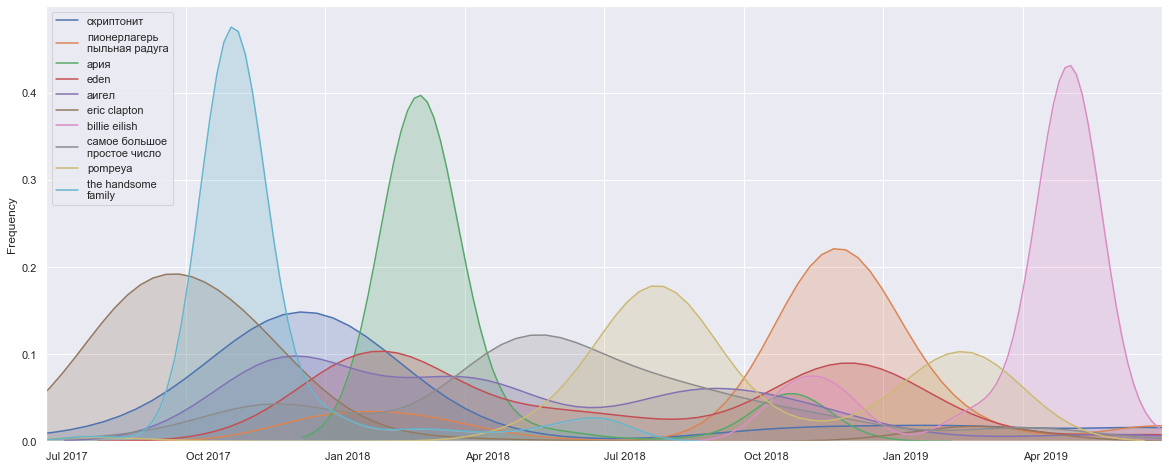

In [39]:
sns.set(rc={'figure.figsize':(20, 8)})
sns.set_palette(sns.color_palette(n_colors=10))
for i in list(top10_artists.artist):
    fig = sns.kdeplot(my_activity.loc[my_activity.artist == i]['month_count'], 
                      label=i, shade=True)
min_p, max_p = my_activity.month_count.min(), my_activity.month_count.max()
fig.set_xticks(np.arange(min_p, max_p, 3))
fig.set_xticklabels(my_activity.month_year_name.unique()[::3], 
                    horizontalalignment='left')
fig.set_ylabel('Frequency')

i, labels = fig.get_legend_handles_labels()
labels = [fill(l, 15) for l in labels]
fig.legend(i, labels)

plt.xlim(min_p, max_p)
plt.show()

## Artist cloud

In [40]:
artist_cloud = dict()

all_artists = my_activity. \
    groupby('artist', as_index=False). \
    agg({'datetime': 'count'}). \
    rename(columns={'datetime': 'count', 'artist': 'name'})
all_artists = all_artists.loc[all_artists['count'] > 1]

for i, i_artist in all_artists.iterrows():
    artist_cloud[i_artist['name']] = i_artist['count']

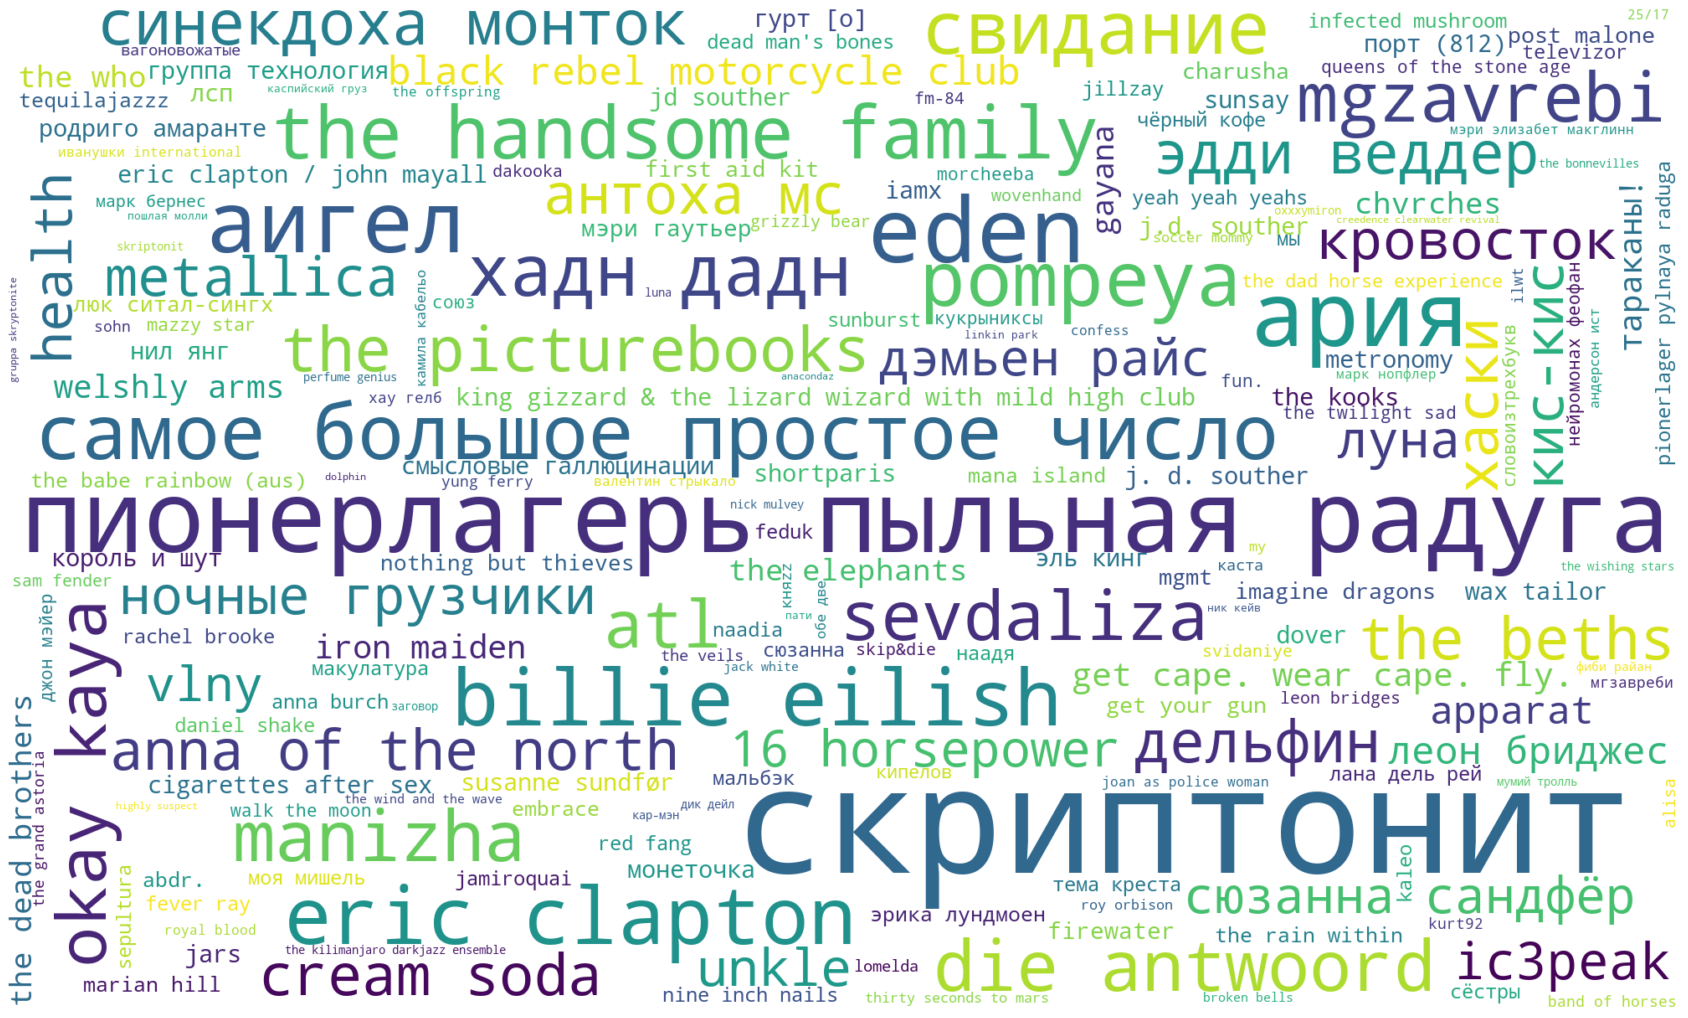

In [41]:
plt.figure(figsize=(30, 30))
wordcloud = WordCloud(background_color="white",
                      width=2000, height=1200). \
    generate_from_frequencies(artist_cloud)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Last.fm tag cloud

In [25]:
tag_cloud = dict()
API_KEY = "5f779cbcc9feb8326d787ab667df952a"
API_SECRET = "0478d752ecf25b5526935d7360c0b8cd"

all_artists = my_activity. \
    groupby('artist', as_index=False). \
    agg({'datetime': 'count'}). \
    rename(columns={'datetime': 'count', 'artist': 'name'})
all_artists = all_artists.loc[all_artists['count'] > 1]

network = pylast.LastFMNetwork(api_key=API_KEY, api_secret=API_SECRET)
for i, i_artist in all_artists.iterrows():
    artist = network.get_artist(i_artist['name'])
    try:
        tags = artist.get_top_tags(limit=5)
    except pylast.WSError: continue
    for tag in tags:
        weight = float(tag.weight)
        if weight < 50: break
        tag_cloud[tag.item.name] = tag_cloud.setdefault(tag.item.name, 0)
        tag_cloud[tag.item.name] += weight * i_artist['count']

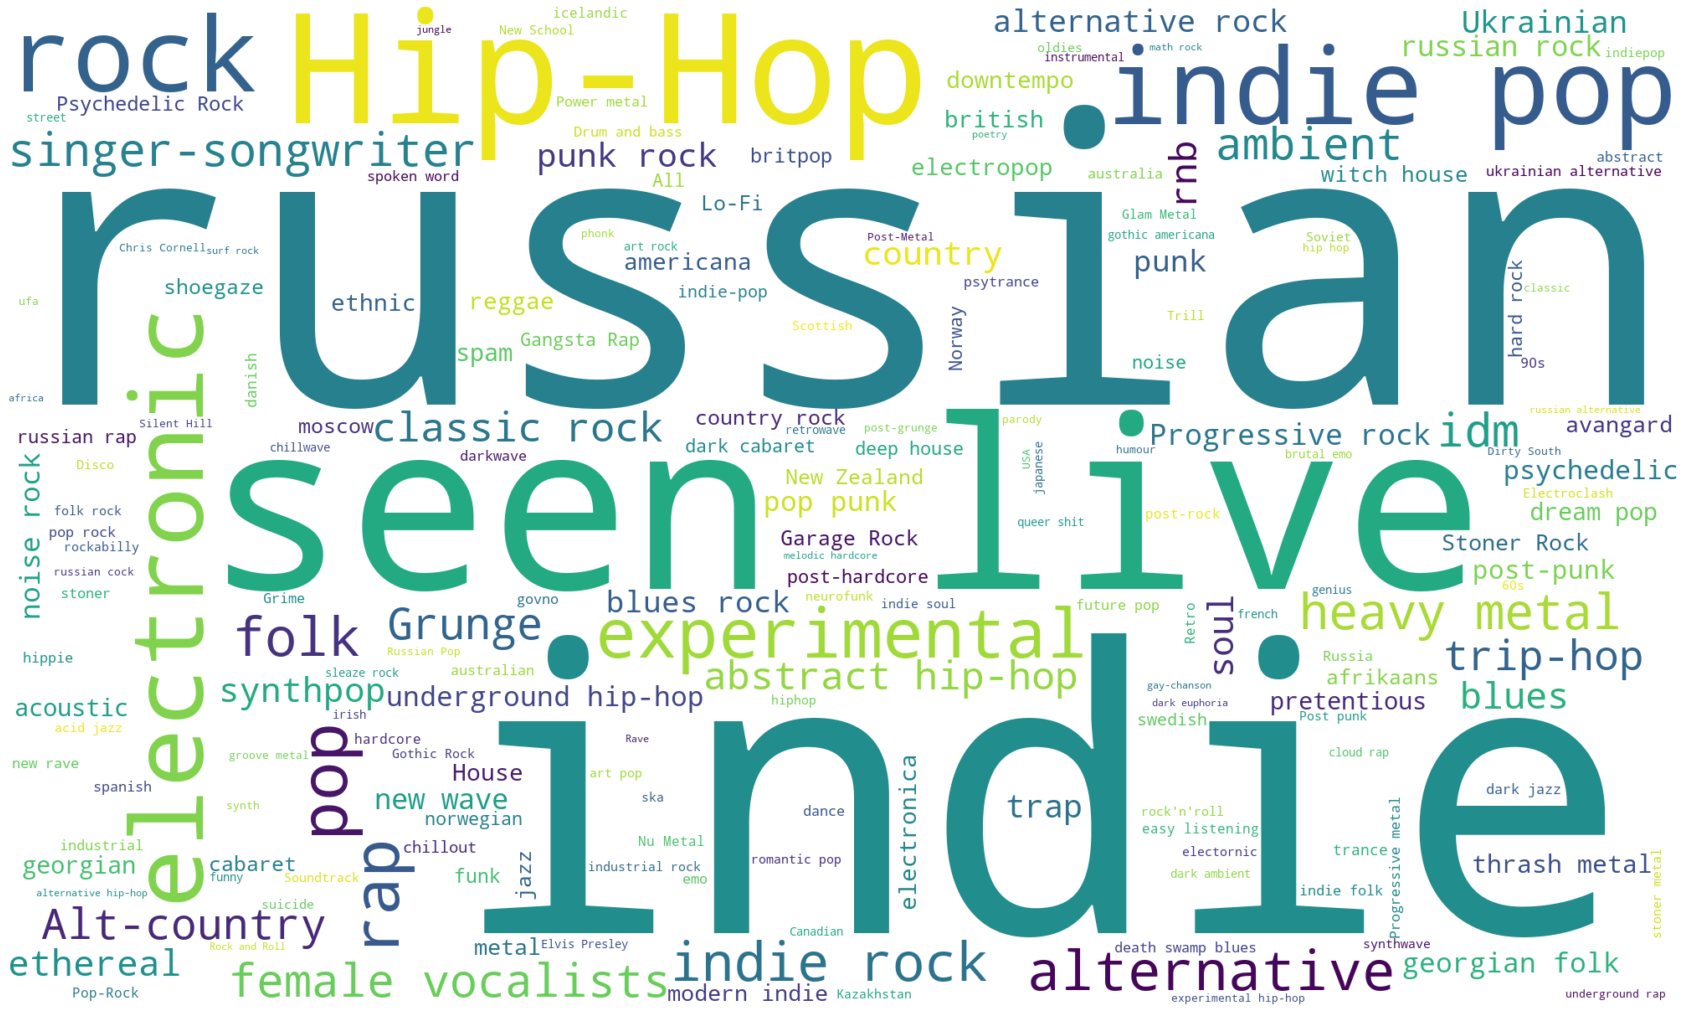

In [26]:
plt.figure(figsize=(30, 30))
wordcloud = WordCloud(background_color="white",
                      width=2000, height=1200). \
    generate_from_frequencies(tag_cloud)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()